# ADDITIONAL ANALYSES: ADDING SEX, AGE and ULCERATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['font.family'] = "Times New Roman"

In [2]:
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     RepeatedStratifiedKFold, cross_validate)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline
from sklearn.feature_selection import SelectFromModel

In [3]:
RANDOM_STATE = 0

In [33]:
dat_supp = pd.read_csv("data/supplementary_data.csv")

In [34]:
X_supp = dat_supp.dropna().drop(columns=['EVOL_METASTASIS'])
y_supp = dat_supp.dropna().loc[:,'EVOL_METASTASIS'].values.astype(int)

In [35]:
#The new matrix includes now ulceration, sex and age as another predictors
print("The size of this matrix is = ", X_supp.shape)

The size of this matrix is =  (267, 12)


In [8]:
clf = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
scaler = RobustScaler()
ros = RandomOverSampler(random_state=RANDOM_STATE)
feat = SelectFromModel(LogisticRegression(C=0.1, class_weight='balanced', penalty='l2', random_state=RANDOM_STATE),
                       threshold=-np.inf)

scoring = {'acc': 'accuracy',
           'bac': 'balanced_accuracy',
           'rec': 'recall',
           'prec': 'precision',
          'roc':'roc_auc',
          'avg': 'average_precision',
          'f1w':'f1_weighted'}

In [9]:
pip = pipeline.Pipeline([('scaler', scaler), ('ros', ros), ('feat', feat), ('clf', clf)])    

param_grid_supp = {'clf__C':np.logspace(-3, 2, 10)}
param_grid_supp['feat__max_features'] = range(1, X_supp.shape[1] + 1)

grid = GridSearchCV(estimator=pip, 
                    param_grid=param_grid_supp, 
                    scoring='balanced_accuracy', iid=False,
                    cv= StratifiedKFold(n_splits=10, random_state=RANDOM_STATE))

res_all_supp = cross_validate(grid, X_supp, y_supp, 
                     scoring=scoring, 
                     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=RANDOM_STATE),
                     return_estimator=True,
                     return_train_score= True,
                     verbose=1,
                     n_jobs=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.8min finished


In [10]:
print(res_all_supp['test_bac'].mean(), ' ', 
      res_all_supp['test_rec'].mean(), ' ', 
      res_all_supp['test_prec'].mean(), ' ', 
      res_all_supp['test_roc'].mean())

0.8184978354978355   0.7859999999999999   0.6055115440115441   0.8880505050505052


In [11]:
participation= 100*np.array([estim.best_estimator_.named_steps['feat'].get_support() 
                         for estim in res_all_supp['estimator']]).sum(axis=0)/50.0

In [12]:
participation

array([100.,  82., 100.,  24.,  68.,  20.,  28.,  12.,  80.,  22.,  78.,
        14.])

In [14]:
part_folds=1-np.array([estim.best_estimator_.named_steps['feat'].get_support() 
            for estim in res_all_supp['estimator']]).T[np.argsort(participation)[::-1],:]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


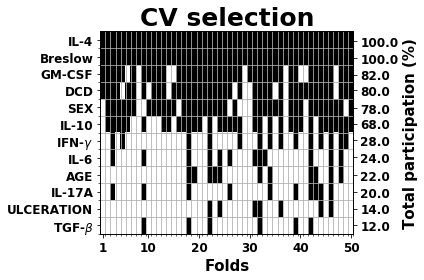

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(part_folds, aspect='auto', cmap='gray')

ax1.set_xlabel("Folds", size=15, fontweight='bold')
ax1.set_xticks([0,9,19,29,39,49])
ax1.set_xticklabels(["1", "10", "20","30","40","50"], size=12, fontweight='bold')

ax1.set_yticks(np.arange(X_supp.shape[1]+1))

ax1.set_yticks(0.5 + np.arange(X_supp.shape[1]), minor=True)
ax1.set_yticklabels(np.array(['Breslow', 'GM-CSF', 'IL-4', 'IL-6', 'IL-10', 
                              'IL-17A', r'IFN-$\gamma$', r'TGF-$\beta$', 
                              'DCD', 'AGE', 'SEX', 'ULCERATION'])[np.argsort(participation)[::-1]],
                   size=12, fontweight='bold')

ax1.set_xticks(0.5 + np.arange(50), minor=True)
ax1.grid(which='minor')
ax1.set_ylim([11.5, -0.5])
#ax2.set_ylim([-5, 15])
ax2= ax1.twinx()

ax2.set_ylim([-0.5, X_supp.shape[1]+2])
ax2.set_yticks([0.1, 1.3, 2.5, 3.7, 5, 6.2, 7.4, 8.5, 9.8, 10.9, 12.1, 13.3])
ax2.set_yticklabels(participation[np.argsort(participation)],
                    size=12, fontweight='bold', minor=False)
ax1.autoscale(False)
ax2.autoscale(False)
ax2.set_ylabel("Total participation (%)", size=15, fontweight="bold")
plt.title("CV selection", size=25, fontweight="bold")
plt.tight_layout()
#plt.savefig('plots/Figure_S3.svg', dpi = 300)
#plt.savefig('plots/Figure_S3.png', dpi = 300)

## BAYES FACTOR ANALYSIS

To compare the possible models of interest coming out from our analyses, let's compute the BIC our proposed model of Breslow, GM-CSF, IL-4 and DCD, to other possible predictive models

In [17]:
from sklearn.linear_model.logistic import _logistic_loss

In [18]:
# Model 1: Breslow + GM-CSF + IL-4 + DCD
X_model_1 = dat_supp.dropna().drop(columns=['EVOL_METASTASIS']).loc[:, ['HIST_BRESLOW_mm', 
                                                                        'GM-CSF', 'IL-4', 
                                                                        'Dermicidina']].values

# Model 2: Model 1 + AGE + SEX + ULCERATION
X_model_2 = dat_supp.dropna().drop(columns=['EVOL_METASTASIS']).loc[:, ['HIST_BRESLOW_mm', 
                                                                        'GM-CSF', 
                                                                        'IL-4', 'Dermicidina', 
                                                                        'AGE', 'SEX', 'HIST_ULCERACION']].values.astype(float)

# Model 3: Breslow + AGE + SEX + ULCERATION (model with predictive factors other than serum variables)
X_model_3 = dat_supp.dropna().drop(columns=['EVOL_METASTASIS']).loc[:, ['HIST_BRESLOW_mm', 
                                                                        'AGE', 'SEX', 
                                                                        'HIST_ULCERACION']].values.astype(float)

# Model 3:Model 1 + SEX (as being one of the most important new features added)
X_model_4 = dat_supp.dropna().drop(columns=['EVOL_METASTASIS']).loc[:, ['HIST_BRESLOW_mm', 
                                                                        'GM-CSF', 'IL-4', 
                                                                        'Dermicidina', 'SEX']].values

y_bic = dat_supp.dropna().loc[:, 'EVOL_METASTASIS'].values

In [19]:
clf = LogisticRegression(class_weight='balanced')
pip = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])    

In [20]:
pip.fit(X_model_1, y_bic)

X_model_1_trans = scaler.fit_transform(X_model_1)

coef_ = np.squeeze(pip.named_steps['clf'].coef_)
alpha = 1 / pip.named_steps['clf'].C

P1 = np.exp(-_logistic_loss(coef_, X_model_1_trans, y_bic, alpha))

n, k = X_model_1_trans.shape
BIC_1 = -2*np.log(P1) + k*np.log(n)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
pip.fit(X_model_2, y_bic)

X_model_2_trans = scaler.fit_transform(X_model_2)

coef_ = np.squeeze(pip.named_steps['clf'].coef_)
alpha = 1 / pip.named_steps['clf'].C

P2 = np.exp(-_logistic_loss(coef_, X_model_2_trans, y_bic, alpha))
n, k = X_model_2_trans.shape
BIC_2 = -2*np.log(P2) + k*np.log(n)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
pip.fit(X_model_3, y_bic)

X_model_3_trans = scaler.fit_transform(X_model_3)

coef_ = np.squeeze(pip.named_steps['clf'].coef_)
alpha = 1 / pip.named_steps['clf'].C

P3 = np.exp(-_logistic_loss(coef_, X_model_3_trans, y_bic, alpha))
n, k = X_model_3_trans.shape
BIC_3 = -2*np.log(P3) + k*np.log(n)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
pip.fit(X_model_4, y_bic)

X_model_4_trans = scaler.fit_transform(X_model_4)

coef_ = np.squeeze(pip.named_steps['clf'].coef_)
alpha = 1 / pip.named_steps['clf'].C

P4 = np.exp(-_logistic_loss(coef_, X_model_4_trans, y_bic, alpha))
n, k = X_model_4_trans.shape
BIC_4 = -2*np.log(P3) + k*np.log(n)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
# BICs
print("BIC model 1 = %.2f\n"
      "BIC model 2 = %.2f\n"
      "BIC model 3 = %.2f\n"
      "BIC model 4 = %.2f"% (BIC_1, BIC_2, BIC_3, BIC_4))

BIC model 1 = 337.18
BIC model 2 = 355.54
BIC model 3 = 343.48
BIC model 4 = 349.07


Let's compute the evidence of our proposed model with respect to the others

In [30]:
B12 = np.exp(0.5*(BIC_2 - BIC_1))
print("Bayes Factor between model with our variables of interest and"
      " the same model including also confoundings = %.3f" % B12)

Bayes Factor between model with our variables of interest and the same model including also confoundings = 9714.965


In [31]:
B13 = np.exp(0.5*(BIC_3 - BIC_1))
print("Bayes Factor between the model with the variables of interest"
      " versus only the confoundings = %.3f" % B13)

Bayes Factor between the model with the variables of interest versus only the confoundings = 23.392


In [32]:
B14 = np.exp(0.5*(BIC_4 - BIC_1))
print("Bayes Factor between the model with the variables of interest"
      " versus only the confoundings = %.3f" % B14)

Bayes Factor between the model with the variables of interest versus only the confoundings = 382.225
